## 1. Import Relevant Packages

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from scipy import stats
import datetime as dt
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt

#pyfolio
import pyfolio as pf
%matplotlib inline
import empyrical

/Users/christinemering/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Define start and end periods for results
start = '2005-01-01'
end = '2020-12-31'

## 2. Importing fama french five factor data

In [3]:
# Loading Fama French 3 Factors (only include rows with factors)
ff5f = pd.read_csv('FF5Fdaily.csv', skiprows = 3, nrows=24896, index_col = 0)
ff5f.index = pd.to_datetime(ff5f.index, format = '%Y%m%d').tz_localize('UTC')
ff5f.index = ff5f.index.rename("date")

# Start at start date, end at end date
ff5f = ff5f[ff5f.index >= start]
ff5f = ff5f[ff5f.index <= end]

ff5f

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2005-01-03 00:00:00+00:00,-0.97,-0.65,-0.10,0.34,-0.02,0.008
2005-01-04 00:00:00+00:00,-1.30,-0.51,0.45,0.84,-0.49,0.008
2005-01-05 00:00:00+00:00,-0.51,-1.12,0.00,0.10,-0.14,0.008
2005-01-06 00:00:00+00:00,0.34,-0.04,0.13,0.49,-0.13,0.008
2005-01-07 00:00:00+00:00,-0.22,-0.83,-0.10,-0.17,-0.02,0.008
...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,0.21,-0.43,-0.17,0.24,-0.05,0.000
2020-12-28 00:00:00+00:00,0.46,-0.65,0.32,1.46,0.50,0.000
2020-12-29 00:00:00+00:00,-0.40,-1.42,0.24,0.75,-0.28,0.000


In [4]:
# Get in decimal format 
ff5f = ff5f / 100

# Ensuring no errors 
ff5f['RF'] = pd.to_numeric(ff5f['RF'], errors='coerce') 
ff5f['Mkt-RF'] = pd.to_numeric(ff5f['Mkt-RF'], errors='coerce') 

In [5]:
# Calculating market return
ff5f['Mkt'] = ff5f['Mkt-RF'] + ff5f['RF']

In [6]:
ff5f

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt
date,,,,,,,
2005-01-03 00:00:00+00:00,-0.0097,-0.0065,-0.0010,0.0034,-0.0002,0.00008,-0.00962
2005-01-04 00:00:00+00:00,-0.0130,-0.0051,0.0045,0.0084,-0.0049,0.00008,-0.01292
2005-01-05 00:00:00+00:00,-0.0051,-0.0112,0.0000,0.0010,-0.0014,0.00008,-0.00502
2005-01-06 00:00:00+00:00,0.0034,-0.0004,0.0013,0.0049,-0.0013,0.00008,0.00348
2005-01-07 00:00:00+00:00,-0.0022,-0.0083,-0.0010,-0.0017,-0.0002,0.00008,-0.00212
...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000,0.00210
2020-12-28 00:00:00+00:00,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000,0.00460
2020-12-29 00:00:00+00:00,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000,-0.00400


## 3. Importing Betting Against Beta Data

In [7]:
bab_returns = pd.read_excel('bab_daily.xlsx', index_col=0, parse_dates=True)
bab_returns.index = pd.to_datetime(bab_returns.index).tz_localize('UTC')
bab_returns.index = bab_returns.index.rename("date")
bab_returns = bab_returns.rename(columns={'returns':'BAB'})

# Start at start date, end at end date
bab_returns = bab_returns[bab_returns.index >= start]
bab_returns = bab_returns[bab_returns.index <= end]

In [8]:
# Already in decimal format
bab_returns 

,BAB
date,
2005-01-03 00:00:00+00:00,-0.004195
2005-01-04 00:00:00+00:00,0.005905
2005-01-05 00:00:00+00:00,-0.000007
2005-01-06 00:00:00+00:00,0.001988
2005-01-07 00:00:00+00:00,0.001726
...,...
2020-12-25 00:00:00+00:00,-0.000002
2020-12-28 00:00:00+00:00,-0.001937
2020-12-29 00:00:00+00:00,-0.000509


## 4. Importing MOM results

In [9]:
MOM_results = pd.read_csv('MOM.csv', low_memory=False, index_col=0)
MOM_results.index = pd.to_datetime(MOM_results.index).tz_localize('UTC')

# Start at start date, end at end date
MOM_results = MOM_results[MOM_results.index >= start]
MOM_results = MOM_results[MOM_results.index <= end]

# Renaming columns
MOM_results = MOM_results.rename(columns={'long_short':'mom'})
MOM_results.index = MOM_results.index.rename("date")

# Already in decimal format
MOM_results

,mom
date,
2005-01-03 00:00:00+00:00,-0.009538
2005-01-04 00:00:00+00:00,0.004530
2005-01-05 00:00:00+00:00,0.002246
2005-01-06 00:00:00+00:00,0.004519
2005-01-07 00:00:00+00:00,-0.004702
...,...
2020-12-24 00:00:00+00:00,0.004464
2020-12-28 00:00:00+00:00,-0.029692
2020-12-29 00:00:00+00:00,-0.002533


## 4. Regression

In [10]:
mom_ff5f = pd.merge(MOM_results, ff5f,
                    on='date', how='left')

mom_ff5f = pd.merge(mom_ff5f, bab_returns,
                    on='date', how='left')

In [11]:
# Subtracting the risk free rate from the mom_long_short returns
mom_ff5f['Mom-RF'] = mom_ff5f['mom'] - mom_ff5f['RF']

mom_ff5f.describe()

,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt,BAB,Mom-RF
count,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000,4028.000000
mean,0.000099,0.000413,0.000022,-0.000120,0.000106,-0.000023,0.000048,0.000461,0.000228,0.000051
std,0.015634,0.012531,0.006022,0.007466,0.003774,0.003143,0.000064,0.012530,0.007882,0.015633
min,-0.206343,-0.120000,-0.045800,-0.048900,-0.026100,-0.018100,0.000000,-0.119940,-0.067045,-0.206343
25%,-0.006236,-0.004100,-0.003400,-0.003100,-0.002000,-0.001800,0.000000,-0.004100,-0.002329,-0.006270
50%,0.000782,0.000800,0.000000,-0.000200,0.000100,-0.000100,0.000010,0.000890,0.000431,0.000714
75%,0.007173,0.005800,0.003400,0.002600,0.002100,0.001625,0.000080,0.005812,0.003238,0.007144
max,0.089446,0.113500,0.057300,0.067000,0.018400,0.019700,0.000220,0.113540,0.079389,0.089436


**The five factors:**
* RMt is the return on the value-weight (VW) market portfolio
* SMBt is the return on a diversified portfolio of small stocks minus the return on a diversified portfolio of big stocks
* HMLt is the difference between the returns on diversified portfolios of high and low B/M stocks
* RMWt is the difference between the returns on diversified portfolios of stocks with robust and weak profitability
* CMAt is the difference between the returns on diversified portfolios of the stocks of low and high investment firms, which we call conservative and aggressive

In [12]:
# Defining X and y for regression
y = mom_ff5f['Mom-RF']
X = mom_ff5f[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'BAB']]

# Adding constant
X_sm = sm.add_constant(X)

In [13]:
# Running the regression model
model = sm.OLS(y, X_sm)
results = model.fit(cov_type='HAC',cov_kwds={'maxlags':1})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Mom-RF   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     166.0
Date:                Tue, 06 Apr 2021   Prob (F-statistic):          4.52e-189
Time:                        22:38:52   Log-Likelihood:                 12392.
No. Observations:                4028   AIC:                        -2.477e+04
Df Residuals:                    4021   BIC:                        -2.473e+04
Df Model:                           6                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.412      0.158      -0.001       0.000
Mkt-RF         0.0820      0.028      2.966      0.003       0.028       0.136
SMB            0.2015      0.042      4.838      0.000       0.120       0.283
HML           -1.1368      0.049    -23.082      0.000      -1.233      -1.040
RMW           -0.0325      0.071     -0.456      0.648      -0.172       0.107
CMA            0.0470      0.089      0.528      0.597      -0.127       0.221
BAB            0.6376      0.049     13.139      0.000       0.542       0.733
==============================================================================
Omnibus:                      445.747   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3563.457
Skew:                          -0.199   Prob(JB):                         0.00
Kurtosis:                       7.591   Cond. No.                         363.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

## 5. Regression after removal of insignificant portfolios

In [14]:
# Defining new relevant X, consisting of significant portfolios
X_rel = mom_ff5f[['Mkt-RF', 'SMB', 'HML', 'BAB']] # excluding RMW and CMA

# Adding constant
X_rel_sm = sm.add_constant(X_rel)

In [15]:
# Running the regression model
model_rel = sm.OLS(y, X_rel_sm)
results_rel = model_rel.fit(cov_type='HAC',cov_kwds={'maxlags':1})
results_rel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Mom-RF   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     248.0
Date:                Tue, 06 Apr 2021   Prob (F-statistic):          1.11e-190
Time:                        22:38:52   Log-Likelihood:                 12391.
No. Observations:                4028   AIC:                        -2.477e+04
Df Residuals:                    4023   BIC:                        -2.474e+04
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.425      0.154      -0.001       0.000
Mkt-RF         0.0808      0.027      2.973      0.003       0.028       0.134
SMB            0.2047      0.040      5.139      0.000       0.127       0.283
HML           -1.1268      0.047    -23.862      0.000      -1.219      -1.034
BAB            0.6396      0.049     13.092      0.000       0.544       0.735
==============================================================================
Omnibus:                      444.713   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3546.399
Skew:                          -0.198   Prob(JB):                         0.00
Kurtosis:                       7.580   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

## 6. Replicating portfolio

In [16]:
# Relative weights in percent:
results_rel.params[1:] / results_rel.params[1:].sum()

Mkt-RF   -0.400368
SMB      -1.014650
HML       5.585601
BAB      -3.170583
dtype: float64

In [17]:
results_rel_np = np.array(results_rel.params[1:] / results_rel.params[1:].sum())
results_rel_np[1] # test

-1.0146499367950241

In [18]:
# Leverage
results_rel.params[1:].sum()

-0.2017415211996859

In [19]:
# Alpha
print("\nDaily Alpha:", results_rel.params[0])
print("Annualized Alpha:", (1 + results_rel.params[0])**252 - 1)


Daily Alpha: -0.00026860836757007186
Annualized Alpha: -0.06545771210216478


In [20]:
# Dataframe with replicated Portfolio
rep_pf = pd.DataFrame()
rep_pf['rep_pf'] = (results_rel_np[0] * mom_ff5f['Mkt-RF'] +
                   results_rel_np[1] * mom_ff5f['SMB']  + 
                   results_rel_np[2] * mom_ff5f['HML']  + 
                   results_rel_np[3] * mom_ff5f['BAB'])

In [21]:
# Dataframe with momentum and replicated portfolio
mom_rep_pf = pd.DataFrame()
mom_rep_pf['mom'] = mom_ff5f['mom']
mom_rep_pf['rep_pf'] = rep_pf['rep_pf']

mom_rep_pf

,mom,rep_pf
date,,
2005-01-03 00:00:00+00:00,-0.009538,0.018194
2005-01-04 00:00:00+00:00,0.004530,0.016793
2005-01-05 00:00:00+00:00,0.002246,0.013427
2005-01-06 00:00:00+00:00,0.004519,0.000002
2005-01-07 00:00:00+00:00,-0.004702,-0.001757
...,...,...
2020-12-24 00:00:00+00:00,0.004464,-0.013882
2020-12-28 00:00:00+00:00,-0.029692,0.028769
2020-12-29 00:00:00+00:00,-0.002533,0.031030


In [22]:
# Cumulative returns
mom_cum_ret = (1 + mom_rep_pf['mom']).cumprod()
rep_pf_cum_ret = (1 + mom_rep_pf['rep_pf']).cumprod()

Start date,2005-01-03
End date,2020-12-31
Total months,191
,Backtest
Annual return,-53.8%
Cumulative returns,-100.0%
Annual volatility,86.1%
Sharpe ratio,-0.46
Calmar ratio,-0.54
Stability,0.95
Max drawdown,-100.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.00,2008-09-19,2020-12-22,NaT,NaN
1,69.83,2006-07-21,2008-07-15,2008-09-19,566
2,22.21,2005-11-01,2006-03-31,2006-05-19,144
3,18.06,2005-04-20,2005-08-03,2005-10-12,126
4,7.86,2005-01-24,2005-02-08,2005-03-16,38


Stress Events,mean,min,max
Lehman,2.44%,-25.94%,37.56%
EZB IR Event,0.27%,-5.15%,4.96%
Flash Crash,-0.02%,-2.33%,4.49%
Apr14,0.42%,-4.92%,5.39%
GFC Crash,0.16%,-36.87%,41.13%


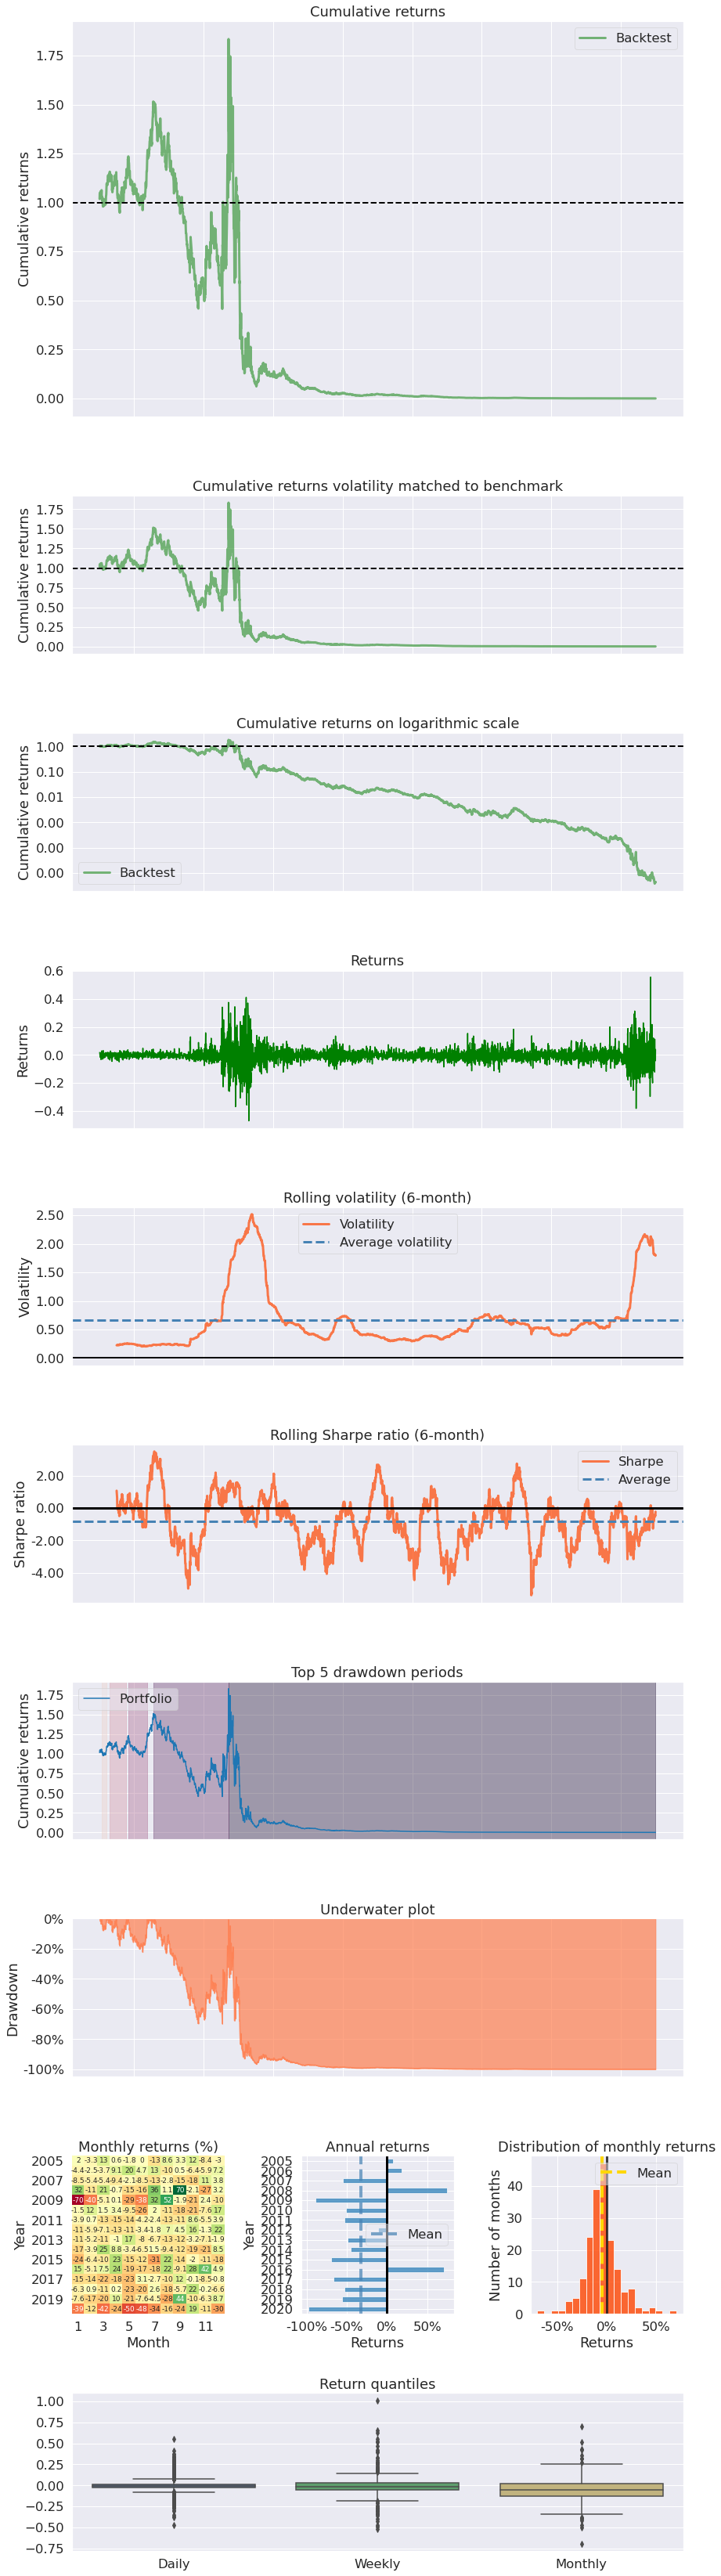

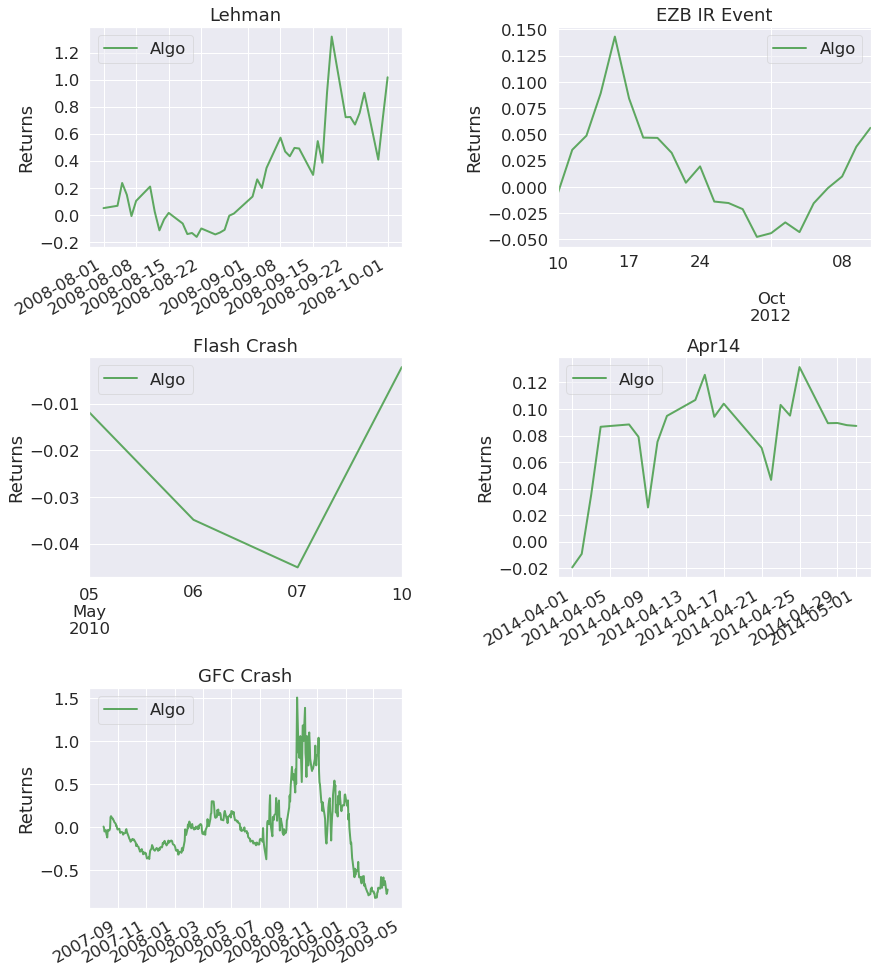

In [23]:
rep_returns = mom_rep_pf['rep_pf']
pf.create_full_tear_sheet(rep_returns,)

Max analysis

In [24]:
rep_pf_max = mom_rep_pf['rep_pf'].max()

In [25]:
mom_rep_pf[mom_rep_pf['rep_pf'] == rep_pf_max]

,mom,rep_pf
date,,
2020-11-09 00:00:00+00:00,-0.206343,0.55633


In [26]:
mom_ff5f[mom_ff5f.index == '2020-11-09 00:00:00+00:00'] # High weight in HML drives the big return

,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt,BAB,Mom-RF
date,,,,,,,,,,
2020-11-09 00:00:00+00:00,-0.206343,0.0082,0.0268,0.067,0.0049,0.009,0.0,0.0082,-0.067045,-0.206343


Min analysis

In [27]:
rep_pf_min = mom_rep_pf['rep_pf'].min()

In [28]:
mom_rep_pf[mom_rep_pf['rep_pf'] == rep_pf_min]

,mom,rep_pf
date,,
2009-04-20 00:00:00+00:00,0.07934,-0.469626


In [29]:
mom_ff5f[mom_ff5f.index == '2009-04-20 00:00:00+00:00'] # Negative weight in BAB drives the negative return

,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt,BAB,Mom-RF
date,,,,,,,,,,
2009-04-20 00:00:00+00:00,0.07934,-0.0432,-0.0082,-0.0436,0.0051,0.0035,0.00001,-0.04319,0.079389,0.07933


## LSTM results

In [ ]:
# Loading LSTM daily returns dataframe
LSTM_results = pd.read_csv('LSTM_results.csv', low_memory=False, index_col=0)
LSTM_results = LSTM_results[LSTM_results.index >= start]
LSTM_results = LSTM_results[LSTM_results.index <= end]
LSTM_results = LSTM_results.rename(columns={'long_short':'LSTM_long_short'})

## MLP

In [ ]:
# Loading LSTM daily returns dataframe
MLP_results = pd.read_csv('MLP_results.csv', low_memory=False, index_col=0)
MLP_results = MLP_results[MLP_results.index >= start]
MLP_results = MLP_results[MLP_results.index <= end]
MLP_results = MLP_results.rename(columns={'long_short':'MLP_long_short'})

### XGBoost

In [ ]:
# Loading LSTM daily returns dataframe
XGBoost_results = pd.read_csv('MLP_results.csv', low_memory=False, index_col=0)
XGBoost_results = XGBoost_results[XGBoost_results.index >= start]
XGBoost_results = XGBoost_results[XGBoost_results.index <= end]
XGBoost_results = XGBoost_results.rename(columns={'long_short':'XGBoost_long_short'})